In [1]:
import pandas as pd

In [2]:
# Load dataset
df = pd.read_csv('reduced_data.csv')

In [3]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

# Sample features and labels
num_nodes = 200
num_node_features = 6  # For BMI, Sex, Age, PhysHlth, MentHlth, GenHlth
num_classes = 2  # Diabetic and HeartDisease

# Generate dummy features and labels
torch.manual_seed(42)  # For reproducibility
x = torch.randn(num_nodes, num_node_features)
y = torch.randint(0, 2, (num_nodes, num_classes))

# Define edges (dummy example: each node is connected to next and previous node in a loop)
edge_index = torch.tensor([[i, i+1] for i in range(num_nodes-1)] + [[num_nodes-1, 0]], dtype=torch.long)
edge_index = torch.cat([edge_index, edge_index[:, [1, 0]]], dim=0).t()

# Create a PyG data object
data = Data(x=x, edge_index=edge_index, y=y)

# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        # First GCN layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        # Second GCN layer
        x = self.conv2(x, edge_index)
        return x



In [4]:

# Initialize model, optimizer, and loss function
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out, data.y.float())
    loss.backward()
    optimizer.step()
    return loss.item()



In [17]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate():
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        y_pred_prob = torch.sigmoid(out)
        y_pred = (y_pred_prob > 0.5).type(torch.int).numpy()
        y_true = data.y.numpy()

        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')
        f1 = f1_score(y_true, y_pred, average='macro')
        auc_roc = roc_auc_score(y_true, y_pred_prob.numpy(), average='macro', multi_class='ovr')

        return {
            'epoch': epoch,
            'loss': loss,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc_roc': auc_roc
        }

# Initialize list to collect metrics
results = []

# Training the model
for epoch in range(200):
    loss = train()  # Placeholder for the training function
    if epoch % 10 == 0:
        metrics = evaluate()
        results.append(metrics)
        print(f"Epoch: {epoch}, Loss: {metrics['loss']:.4f}, Metrics: Acc: {metrics['accuracy']:.4f}, "
              f"Prec: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, "
              f"F1: {metrics['f1']:.4f}, AUC-ROC: {metrics['auc_roc']:.4f}")

# Convert results to DataFrame for better visualization
df = pd.DataFrame(results)
print(df)

# Optionally, you can save the results to a CSV file
# df.to_csv('evaluation_results.csv', index=False)

Epoch: 0, Loss: 0.6224, Metrics: Acc: 0.4950, Prec: 0.6963, Recall: 0.6636, F1: 0.6765, AUC-ROC: 0.7582
Epoch: 10, Loss: 0.6271, Metrics: Acc: 0.5050, Prec: 0.6826, Recall: 0.7370, F1: 0.7030, AUC-ROC: 0.7564
Epoch: 20, Loss: 0.6362, Metrics: Acc: 0.5100, Prec: 0.6943, Recall: 0.6973, F1: 0.6899, AUC-ROC: 0.7568
Epoch: 30, Loss: 0.6351, Metrics: Acc: 0.5000, Prec: 0.6909, Recall: 0.6980, F1: 0.6903, AUC-ROC: 0.7606
Epoch: 40, Loss: 0.6293, Metrics: Acc: 0.5100, Prec: 0.6838, Recall: 0.7175, F1: 0.6947, AUC-ROC: 0.7574
Epoch: 50, Loss: 0.6253, Metrics: Acc: 0.4900, Prec: 0.6898, Recall: 0.6825, F1: 0.6804, AUC-ROC: 0.7596
Epoch: 60, Loss: 0.6172, Metrics: Acc: 0.5000, Prec: 0.6832, Recall: 0.7538, F1: 0.7121, AUC-ROC: 0.7589
Epoch: 70, Loss: 0.6296, Metrics: Acc: 0.5150, Prec: 0.6902, Recall: 0.7349, F1: 0.7090, AUC-ROC: 0.7590
Epoch: 80, Loss: 0.6154, Metrics: Acc: 0.5050, Prec: 0.6976, Recall: 0.6798, F1: 0.6854, AUC-ROC: 0.7579
Epoch: 90, Loss: 0.6137, Metrics: Acc: 0.4950, Prec: 0.6

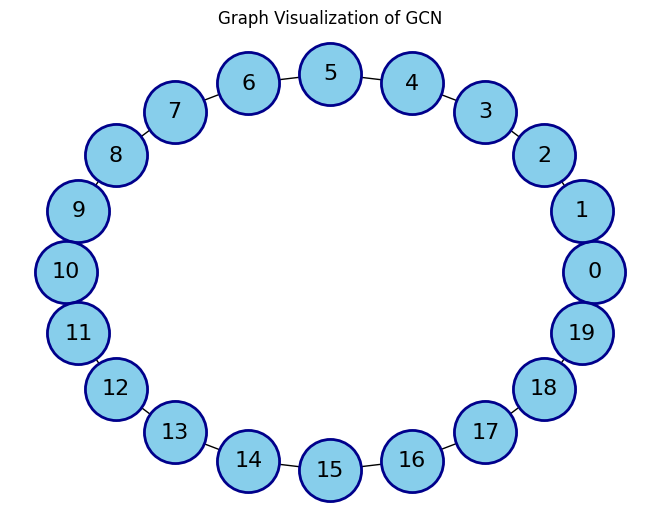

In [21]:
import torch
import matplotlib.pyplot as plt
import networkx as nx

def plot_graph(edge_index, num_nodes):
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    edges = edge_index.t().numpy()
    G.add_edges_from(edges)

    # Generate layout for visualization
    pos = nx.circular_layout(G)  # Circular layout

    # Options for node sizes, colors, and labels for clarity
    node_color = 'skyblue'
    node_size = 2000  # Increase node size
    font_size = 16  # Increase font size for readability

    # Draw the nodes and edges with options for better visualization
    nx.draw(G, pos, node_color=node_color, node_size=node_size, with_labels=True, font_size=font_size, edge_color='k')

    # Add a visual distinction for node borders
    nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=node_size, edgecolors='darkblue', linewidths=2)
    
    plt.title("Graph Visualization of GCN")
    plt.show()

# Sample edge_index for a loop graph
num_nodes = 20  # Adjust number of nodes for simplicity in visualization
edge_index = torch.tensor([[i, (i+1) % num_nodes] for i in range(num_nodes)], dtype=torch.long)
edge_index = torch.cat([edge_index, edge_index[:, [1, 0]]], dim=0).t()

# Call the function to plot the graph
plot_graph(edge_index, num_nodes)


In [18]:

# New patient data
new_patient_features = torch.tensor([[25, 1, 55, 0, 10, 5]], dtype=torch.float)
new_patient_edge_index = torch.tensor([[], []], dtype=torch.long)

# Prediction
with torch.no_grad():
    output = model(new_patient_features, new_patient_edge_index)
    predicted_probabilities = torch.sigmoid(output)
    predicted_classes = (predicted_probabilities > 0.5).int()

# The first class (condition) corresponds to diabetes.
# The second class (condition) corresponds to heart disease.
print("Predicted probabilities:", predicted_probabilities.numpy())
print("Predicted classes (0: No, 1: Yes):", predicted_classes.numpy())

Predicted probabilities: [[0. 1.]]
Predicted classes (0: No, 1: Yes): [[0 1]]


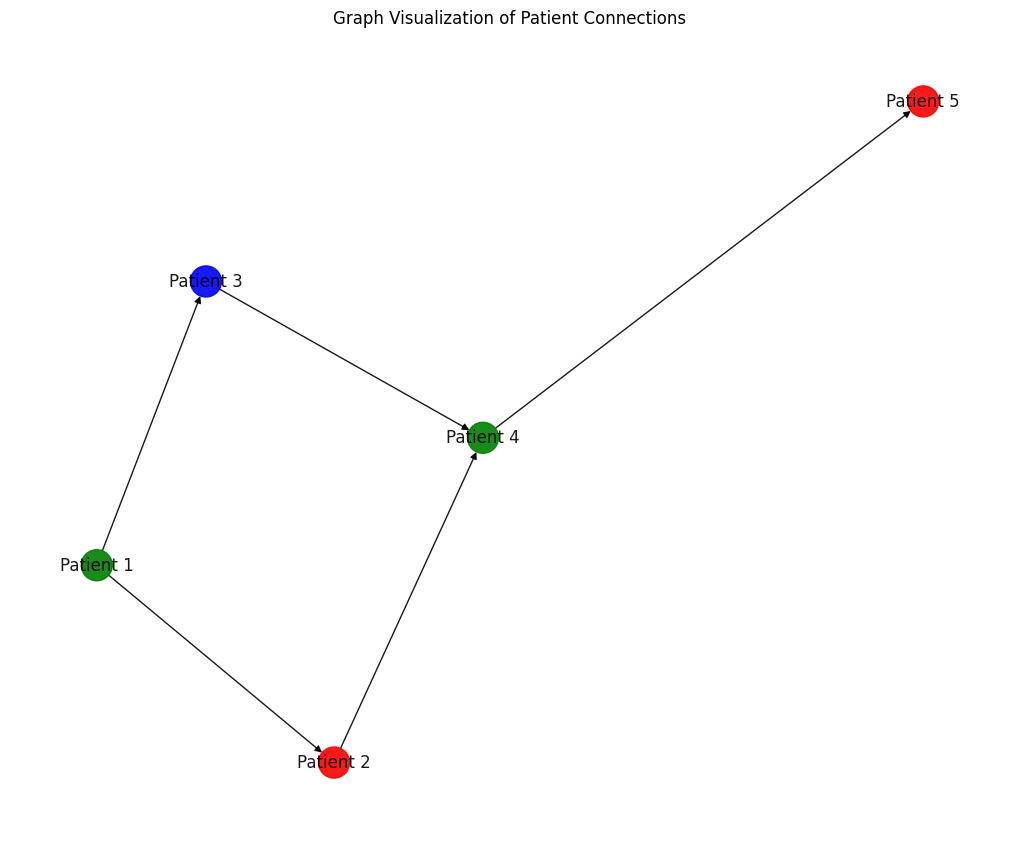

In [19]:

# Create a directed graph
G = nx.DiGraph()

# Add nodes with some attributes
nodes = {
    1: {"label": "Patient 1", "status": "healthy"},
    2: {"label": "Patient 2", "status": "diabetic"},
    3: {"label": "Patient 3", "status": "heart disease"},
    4: {"label": "Patient 4", "status": "healthy"},
    5: {"label": "Patient 5", "status": "diabetic"}
}

for node, attr in nodes.items():
    G.add_node(node, **attr)

# Add edges between nodes
edges = [(1, 2), (1, 3), (2, 4), (3, 4), (4, 5)]
G.add_edges_from(edges)

# Set node colors based on their status
color_map = []
for node in G:
    if G.nodes[node]["status"] == "healthy":
        color_map.append('green')
    elif G.nodes[node]["status"] == "diabetic":
        color_map.append('red')
    else:
        color_map.append('blue')

# set positions for nodes
pos = nx.spring_layout(G)

# Draw the graph
plt.figure(figsize=(10, 8))
nx.draw(G, pos, edge_color='black', width=1, linewidths=1,
        node_size=500, node_color=color_map, alpha=0.9,
        labels={node: G.nodes[node]['label'] for node in G.nodes()})
plt.title('Graph Visualization of Patient Connections')
plt.show()
